# Testing Basic OFDM functions

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from optic.modulation import modulateGray
from optic.metrics     import fastBERcalc, signal_power, theoryBER
from optic.core        import parameters
from optic.models      import photodiode, awgn #ssfm 
from optic.dsp         import lowPassFIR, firFilter, pnorm, pulseShape
from optic.modelsGPU   import ssfm, manakovSSF
from optic.equalization import edc
from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR, hermit, modulateOFDM, demodulateOFDM
from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from tabulate          import tabulate
from optic.plot import plotPSD, pconst

pi = np.pi

In [2]:
#import scienceplots

#plt.style.use('science')
font = {'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

In [3]:
%load_ext autoreload
%autoreload 2

## Parameters

In [118]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
M    = 16                       # Número de símbolos da constelação QAM
Nfft = 512                      # Tamanho da FFT
Ns = int(Nfft/2) - 1            # Número de sub-portadoras
N  = Ns                         # Número de portadoras de informação
Nz = Ns - N                     # Número de subportadoras nulas
G  = 4                          # Tamanho do prefixo cíclico
K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb  = 6e9                       # Taxa de bits/s
Rs  = Rb*Ns*(1 +G/Nfft) / (np.log2(M)*N)      # Banda do sinal
SpS = 4                         # Amostras por símbolo
Fa  = Rs*SpS                    # Frequência de amostragem
Fc  = 193.4e12                  # Frequência da portadora óptica

In [120]:
# Random bits sequency
bits = np.random.randint(2, size = Ns*2**6)

# Maping bits - symbols
symbTx = modulateGray(bits, M, 'qam')
symbTx = pnorm(symbTx) # power normalization

# Pilot carriers
pilot = max(symbTx.real) + 1j*max(symbTx.imag)

# OFDM symbols generation
symbTx_OFDM, symbTx = modulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbTx)

# Upsample + pulse shaping
pulse = pulseShape('rrc', SpS, alpha = 0.01)
pulse = pnorm(pulse)
sigOFDM_Tx = firFilter(pulse, upsample(symbTx_OFDM, SpS))

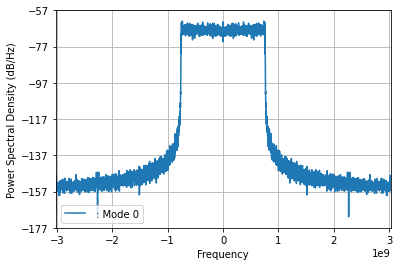

In [114]:
plotPSD(sigOFDM_Tx, Fa);

In [115]:
SNR = 25
sigOFDM_Rx = awgn(sigOFDM_Tx, SNR, Fa, Rs)
sigOFDM_Rx = firFilter(pulse, sigOFDM_Rx)

sigOFDM_Rx = sigOFDM_Rx[0::SpS]

# OFDM demodulation
symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, pnorm(sigOFDM_Rx))

In [116]:
ind = np.arange(1000,len(symbRx)-1000)
BER, _, SNRest = fastBERcalc(symbRx[ind], symbTx[ind], M, 'qam')

EbN0 = SNR - 10*np.log10(np.log2(M))

print('BER = %.2e'%BER)
print('BER(theory) = %.2e'%theoryBER(M, EbN0, 'qam'))
print('SNRest = %.2f'%SNRest)

BER = 1.68e-03
BER(theory) = 6.66e-16
SNRest = 20.96


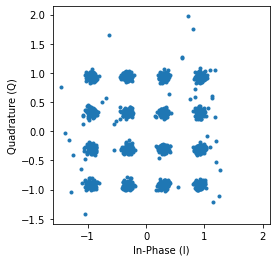

In [121]:
ind = np.arange(1000,len(symbRx)-1000)
pconst(symbRx[ind], pType='fast');